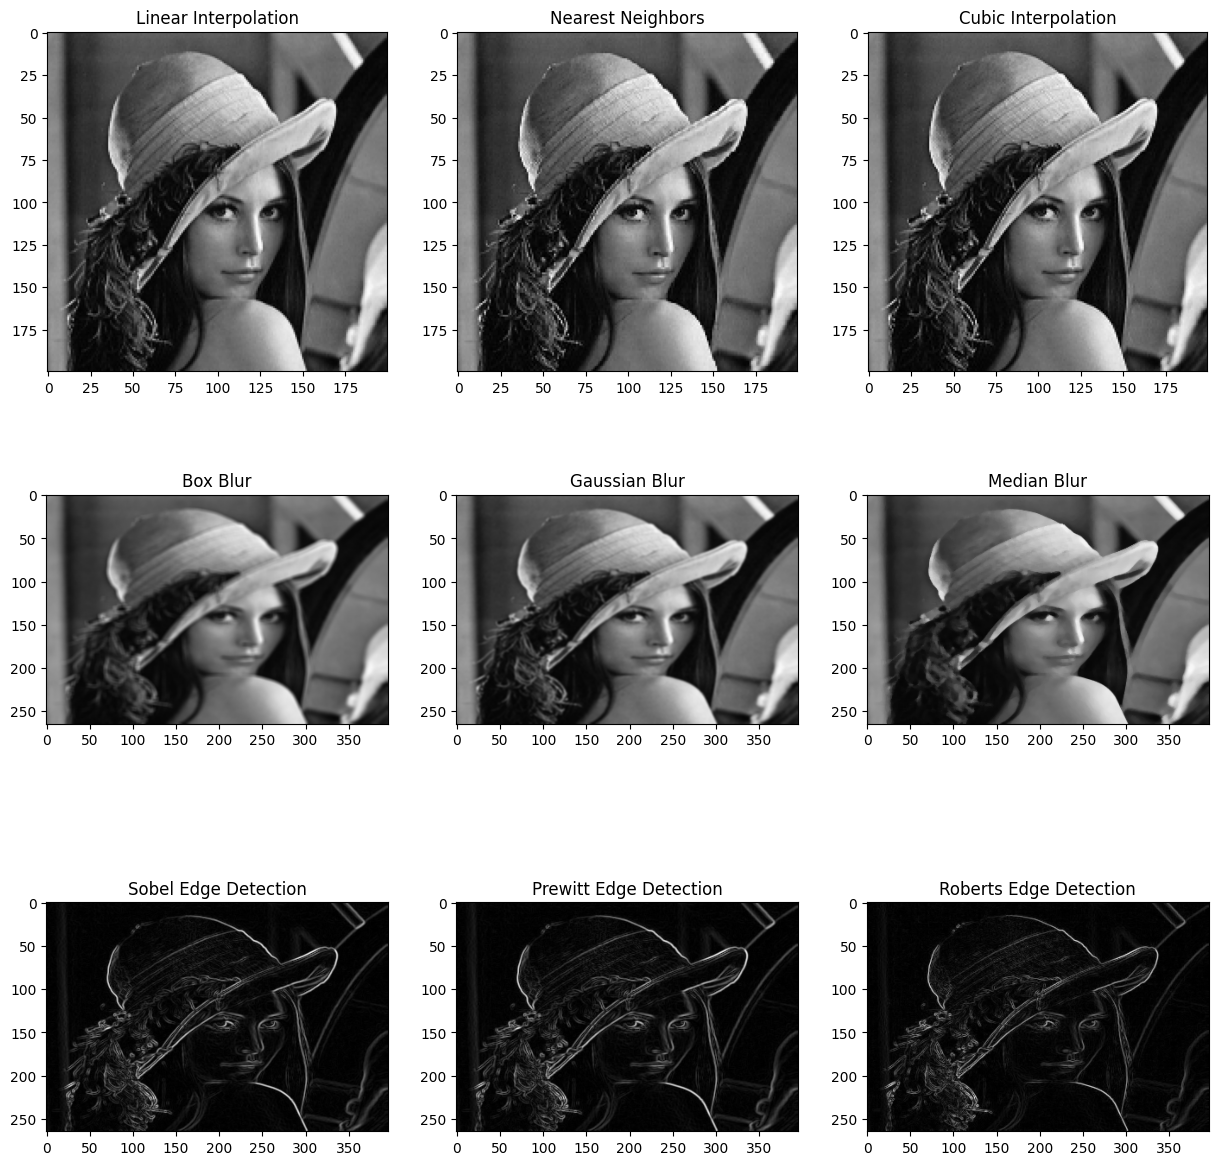

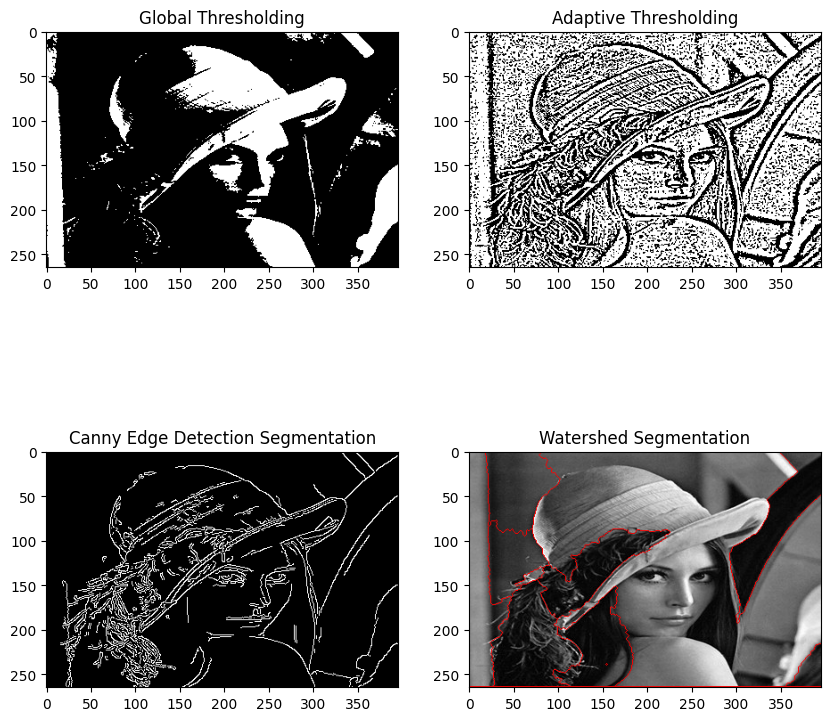

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Accuracy: 0.5558
Precision: 0.6864966027174797
Recall: 0.548447051043586
F1 Score: 0.5089855858364396
Confusion Matrix:
 [[ 870    0    3    5    2    5   31    1   35   28]
 [   0 1079    2    1    0    0   10    0   38    5]
 [  79   25  266   91    5    2  269    4  271   20]
 [  32   39    6  353    2    3   51    8  409  107]
 [  19    2    5    4  168    7   63    7  210  497]
 [  71   25    1   20    3   44   40    2  586  100]
 [  12   12    3    1    1    7  895    0   26    1]
 [   0   15    2   10    5    1    5  280   39  671]
 [  13   72    3    7    3   11   12    4  648  201]
 [   5    7    3    6    1    0    1   13   18  955]]


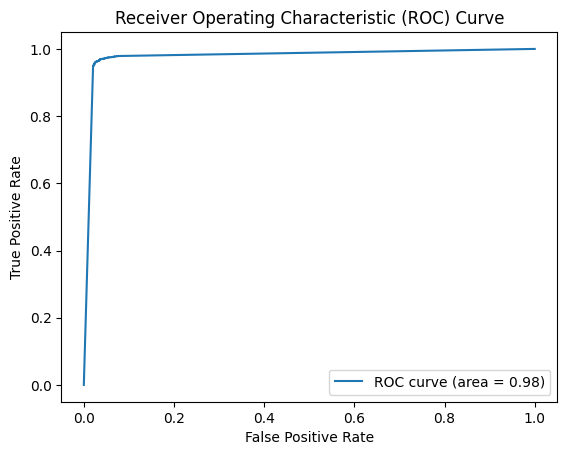

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import sobel, prewitt, roberts
from skimage import io, color
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from tensorflow.keras.datasets import mnist

image = cv2.imread('/content/Picture1.jpg')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

resized_linear = cv2.resize(image, (200, 200), interpolation=cv2.INTER_LINEAR)
resized_nearest = cv2.resize(image, (200, 200), interpolation=cv2.INTER_NEAREST)
resized_cubic = cv2.resize(image, (200, 200), interpolation=cv2.INTER_CUBIC)

box_blur = cv2.blur(image, (5, 5))
gaussian_blur = cv2.GaussianBlur(image, (5, 5), 0)
median_blur = cv2.medianBlur(image, 5)

sobel_edges = sobel(gray_image)
prewitt_edges = prewitt(gray_image)
roberts_edges = roberts(gray_image)
canny_edges = cv2.Canny(gray_image, 100, 200)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes[0, 0].imshow(resized_linear)
axes[0, 0].set_title("Linear Interpolation")
axes[0, 1].imshow(resized_nearest)
axes[0, 1].set_title("Nearest Neighbors")
axes[0, 2].imshow(resized_cubic)
axes[0, 2].set_title("Cubic Interpolation")
axes[1, 0].imshow(box_blur)
axes[1, 0].set_title("Box Blur")
axes[1, 1].imshow(gaussian_blur)
axes[1, 1].set_title("Gaussian Blur")
axes[1, 2].imshow(median_blur)
axes[1, 2].set_title("Median Blur")
axes[2, 0].imshow(sobel_edges, cmap='gray')
axes[2, 0].set_title("Sobel Edge Detection")
axes[2, 1].imshow(prewitt_edges, cmap='gray')
axes[2, 1].set_title("Prewitt Edge Detection")
axes[2, 2].imshow(roberts_edges, cmap='gray')
axes[2, 2].set_title("Roberts Edge Detection")
plt.show()

_, global_thresh = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
adaptive_thresh = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
segmented_canny = canny_edges
gray_blur = cv2.GaussianBlur(gray_image, (5, 5), 0)
_, binary = cv2.threshold(gray_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
sure_bg = cv2.dilate(opening, kernel, iterations=3)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0
markers = cv2.watershed(image, markers)
image[markers == -1] = [255, 0, 0]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(global_thresh, cmap='gray')
axes[0, 0].set_title("Global Thresholding")
axes[0, 1].imshow(adaptive_thresh, cmap='gray')
axes[0, 1].set_title("Adaptive Thresholding")
axes[1, 0].imshow(segmented_canny, cmap='gray')
axes[1, 0].set_title("Canny Edge Detection Segmentation")
axes[1, 1].imshow(image)
axes[1, 1].set_title("Watershed Segmentation")
plt.show()

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)
x_train, x_test = x_train / 255.0, x_test / 255.0

clf1 = GaussianNB()
clf2 = SVC(probability=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf1, x_train, y_train, cv=kf, scoring='accuracy')
clf1.fit(x_train, y_train)
y_pred = clf1.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
conf_matrix = confusion_matrix(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, clf1.predict_proba(x_test)[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()